# Speech Corpora

NB: To run this notebook, you have to create a virtual environment and install the packages in requirements.txt

Read the README.md contained in this folder for more information.

What you need to do
- Record the speech
- Force alignment or manually label the audio
- Extract formants (F1, F2, F3, F4) using Praat
- Extract pitch (F0) using Praat
- Process data to align all data
- Analyse the data 

In [20]:
import os
import funcy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import seaborn as sns
import torch
import torchaudio

from functools import partial
from tgt.io import read_textgrid

In [21]:
datadir = os.path.join(os.getcwd(), "data")

In [22]:
# source: https://clarin.phonetik.uni-muenchen.de/BASWebServices/services/runMAUSGetInventar?LANGUAGE=eng-GB
MAU_phonemes = ['<usb>' '<nib>' '<p:>' '<p>' 'U@' '@U' 'u:' 'tS' 'OI' 'O:' 'o~' 'I@' 'i:'
 'eI' 'E~' 'e@' 'dZ' 'aU' 'aI' 'A:' 'a~' '3:' 'Z' 'z' 'x' 'w' 'V' 'v' 'U'
 'u' 'T' 't' 'S' 's' 'r' 'Q' 'p' 'N' 'n' 'm' 'l' 'k' 'j' 'I' 'i' 'h' 'g'
 'f' 'e' 'D' 'd' 'b' '#' '@' '{' '?' '>' '<']

MAU_vowels = {'u:', 'O:', 'o~', 'i:', 'E~', 'A:', 'a~', '3:', 'V', 'U', 'u', 'Q',
       'I', 'i', 'e', '@', '{'}

# This is only necessary if you used the forced alignment method that uses SAMPA/MAU phonemes.
MAU_IPA_map = {'u:': 'uː', 'O:': 'ɔː', 'o~': 'õ', 'i:': 'iː','E~': 'ɛ̃', 
               'A:': 'ɑː','a~': 'ã', '3:': 'ɜː', 'V': 'ʌ', 'U': 'ʊ',
              'u': 'u', 'Q': 'ɒ', 'I': 'ɪ', 'i': 'i', 'e': 'e', '@': 'ə', '{': 'æ'}

In [23]:
def dynamic_range_compression(x, C=1, clip_val=1e-5):
    """
    Tacotron2's dynamic range compression.

    Args:
    C: compression factor
    """
    return torch.log(torch.clamp(x, min=clip_val) * C)


def dynamic_range_decompression(x, C=1):
    """
    Tacontron2's dynamic range decompression.

    Args:
    C: compression factor used to compress
    """
    return torch.exp(x) / C

def get_phoneme(T_s, phone_tier):
    """
    Retrieve the uttered phoneme at a specific time in the utterance.
    """
    interval = funcy.lfilter(lambda phone: phone.start_time <= T_s <= phone.end_time, phone_tier)

    if len(interval) == 0:
        return np.nan

    return interval[0].text


def get_formants_on_interval(interval, time_array, formants_array):
    """
    Retrieve the formants inside a textgrid interval.
    """
    indices = np.argwhere((time_array >= interval.start_time) & (time_array <= interval.end_time))
    return formants_array[indices]

## Load utterance files

In [24]:
utterance = "ara"
phone_tier_name = "MAU" # ensure to replace this with the name of your phoneme tier

wav_filepath = os.path.join(datadir, "audio", f"{utterance}.wav")
textgrid_filepath = os.path.join(datadir, "textgrid", f"{utterance}.TextGrid")
formants_filepath = os.path.join(datadir, "formants", f"{utterance}.txt")
f0_filepath = os.path.join(datadir, "pitch", f"{utterance}.txt")

textgrid = read_textgrid(textgrid_filepath)
phone_tier = textgrid.get_tier_by_name(phone_tier_name)

In [25]:
df_formants = pd.read_csv(formants_filepath, sep="\s+")
df_formants = df_formants.replace("--undefined--", np.nan)
df_formants = df_formants.astype(float)
df_formants["phoneme"] = df_formants.Time_s.apply(partial(get_phoneme, phone_tier=phone_tier))

# remove places that correspond to silences '<p:>' and '<p>' were designated as silence in MAUS
df_formants = df_formants[(df_formants.phoneme != '<p:>')  & (df_formants.phoneme != '<p>')]

df_f0 = pd.read_csv(f0_filepath, sep="\s+")
df_f0 = df_f0.replace("--undefined--", np.nan)
df_f0 = df_f0.astype(float)

In [26]:
df_formants.tail(10)

,Time_s,F1_Hz,F2_Hz,F3_Hz,F4_Hz,phoneme
374,2.881667,491.200783,2663.165126,3407.404618,4100.301938,k
375,2.887917,421.577708,2584.643175,3276.028186,3897.022895,k
376,2.894167,395.155369,2622.372684,3360.214108,NaN,k
377,2.900417,835.487808,2635.829217,3309.971523,4382.758413,k
378,2.906667,503.007728,2566.394584,3371.584998,4191.383558,k
379,2.912917,472.326618,2587.149878,3335.844255,4146.874170,k
380,2.919167,475.889670,2591.045232,3211.115260,4053.196951,k
381,2.925417,431.174872,2546.675875,2721.507992,3929.829964,k
382,2.931667,429.089885,2520.899859,2821.197138,3557.996814,k
383,2.937917,515.321572,2531.176291,2958.463748,3452.387741,k


## Visualize the waveform + spectrogram

In [27]:
audio, sample_rate = torchaudio.load(wav_filepath)
audio_mono = audio.mean(dim=0)
duration = len(audio_mono) / sample_rate
time = torch.linspace(0., duration, len(audio_mono))

# you may need to change these parameters to match the settings in praat
n_fft = 800
win_length = 800
hop_length = 200
power = 2

spec_transform = torchaudio.transforms.Spectrogram(
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
    power=power
)

spec = spec_transform(audio_mono)
spec = dynamic_range_compression(spec)

In [28]:
audio_mono.shape

torch.Size([149440])

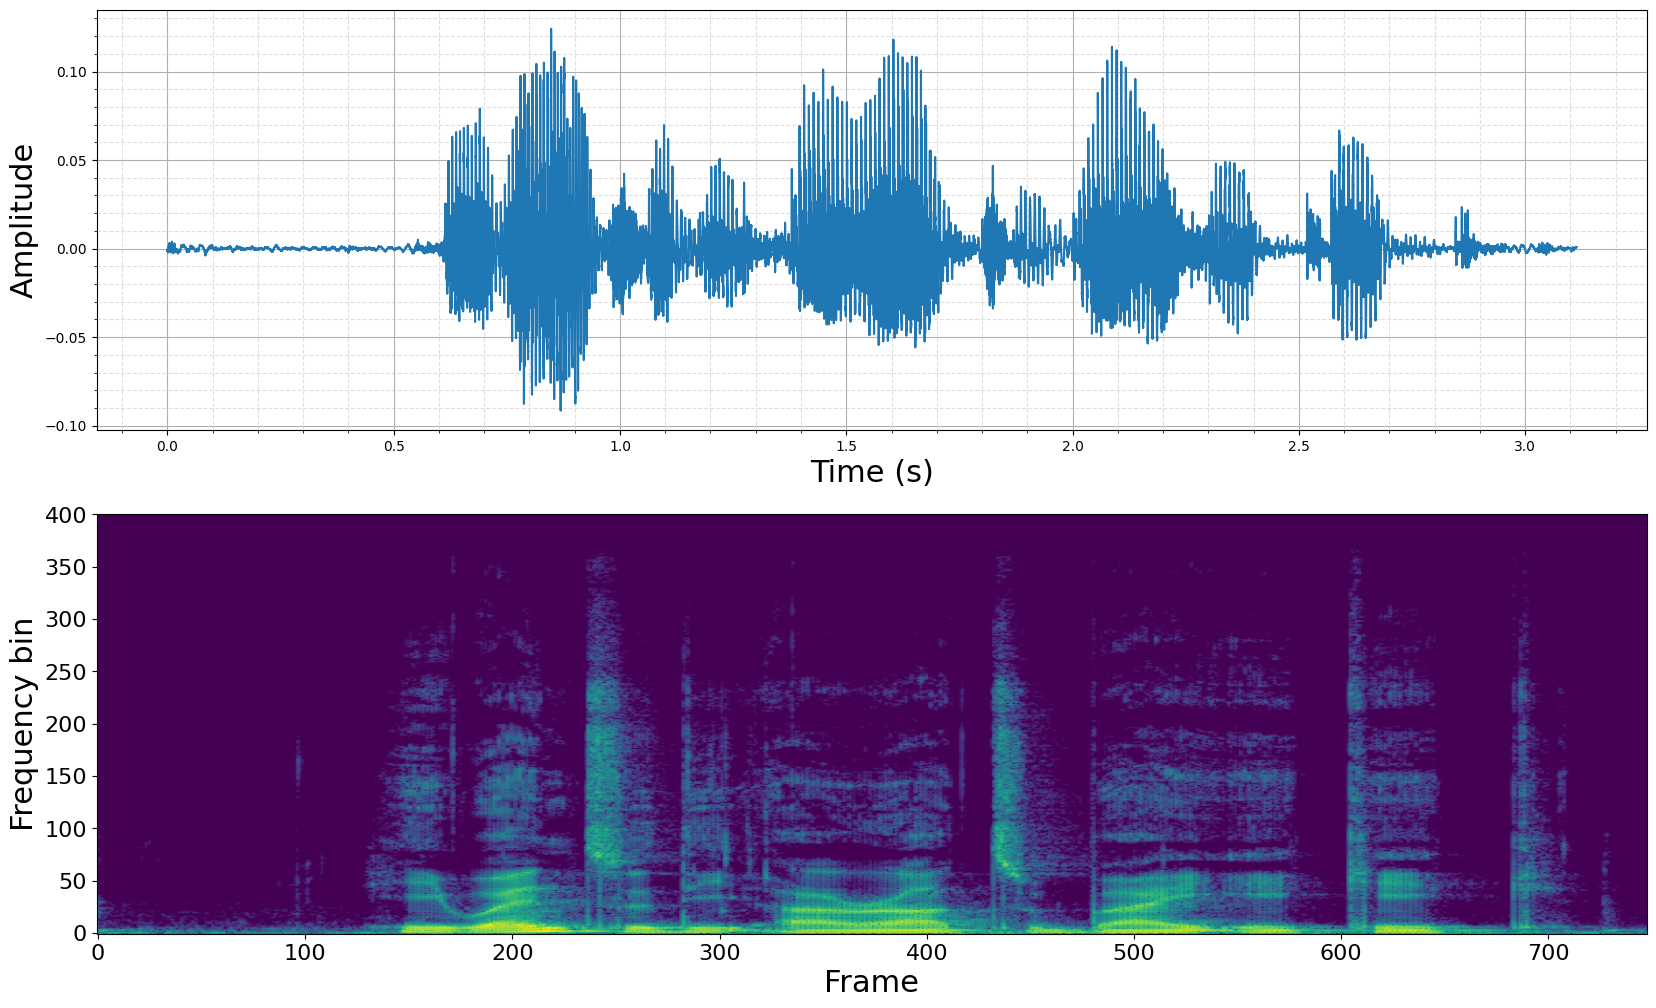

In [29]:
plt.figure(figsize=(20, 12))

plt.subplot(2, 1, 1)

plt.plot(time, audio_mono)
plt.xlabel("Time (s)", fontsize=22)
plt.ylabel("Amplitude", fontsize=22)

plt.grid(which="major")
plt.grid(which="minor", linestyle="--", alpha=0.4)
plt.minorticks_on()

plt.subplot(2, 1, 2)

plt.imshow(spec, origin="lower", aspect="auto")

plt.xlabel("Frame", fontsize=22)
plt.ylabel("Frequency bin", fontsize=22)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.show()

## Plot formants and F0

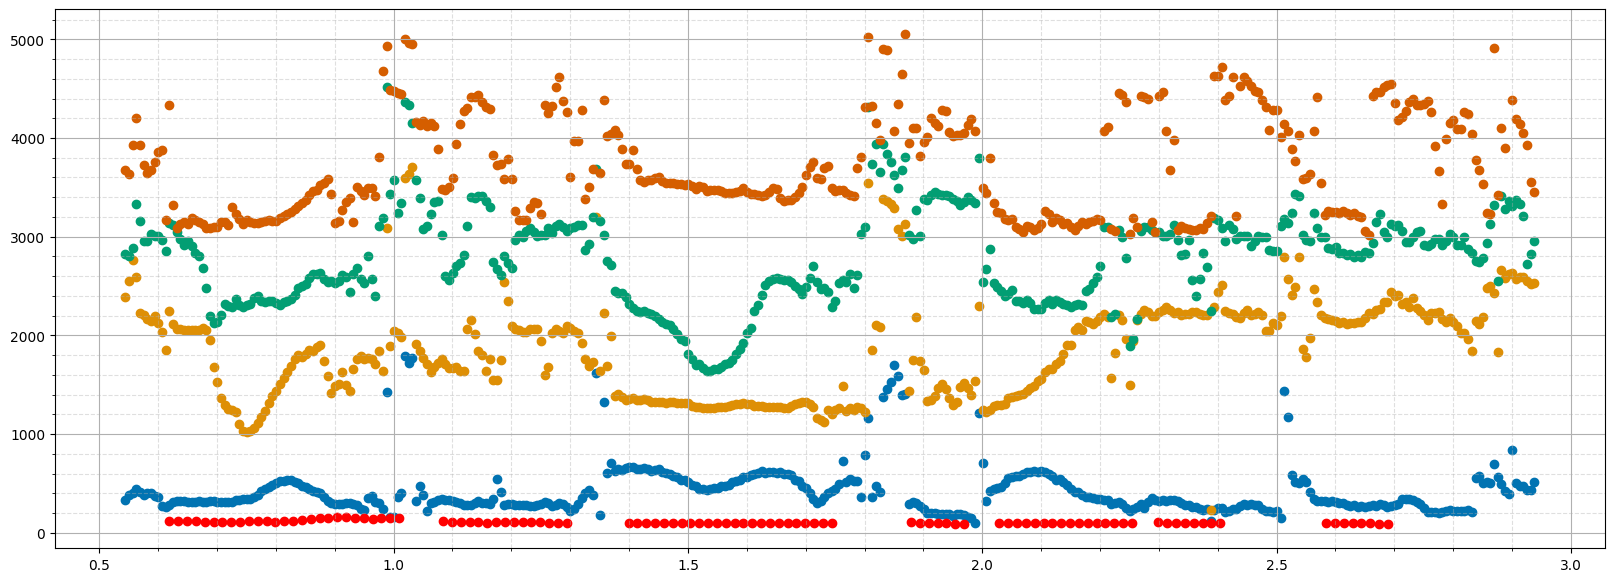

In [30]:
palette = sns.color_palette("colorblind", 4)
F4_mask = df_formants.F4_Hz.isna()

plt.figure(figsize=(20, 7))

plt.scatter(df_formants.Time_s, df_formants.F1_Hz, color=palette[0])
plt.scatter(df_formants.Time_s, df_formants.F2_Hz, color=palette[1])
plt.scatter(df_formants.Time_s, df_formants.F3_Hz, color=palette[2])
plt.scatter(df_formants[~F4_mask].Time_s, df_formants[~F4_mask].F4_Hz, color=palette[3])

plt.scatter(df_f0.Time_s, df_f0.F0_Hz, color="red")

plt.grid(which="major")
plt.grid(which="minor", linestyle="--", alpha=0.4)
plt.minorticks_on()

plt.show()

## Calculate the mean formant frequency for each vowel interval

In [31]:
vowels_data = []

# positions = ["sitting"]
utterances = ["ara", "iri", "uru"]

for utterance in utterances:
    # load the data
    wav_filepath = os.path.join(datadir, "audio", f"{utterance}.wav")
    textgrid_filepath = os.path.join(datadir, "textgrid", f"{utterance}.TextGrid")
    formants_filepath = os.path.join(datadir, "formants", f"{utterance}.txt")
    f0_filepath = os.path.join(datadir, "pitch", f"{utterance}.txt")

    textgrid = read_textgrid(textgrid_filepath)
    phone_tier = textgrid.get_tier_by_name("MAU")

    df_formants = pd.read_csv(formants_filepath, sep="\s+")
    df_formants = df_formants.replace("--undefined--", np.nan)
    df_formants = df_formants.astype(float)
    df_formants["phoneme"] = df_formants.Time_s.apply(partial(get_phoneme, phone_tier=phone_tier))

    df_f0 = pd.read_csv(f0_filepath, sep="\s+")
    df_f0 = df_f0.replace("--undefined--", np.nan)
    df_f0 = df_f0.astype(float)

    # add the data to the global list
    for interval in phone_tier:
        phoneme = interval.text

        if phoneme not in MAU_vowels:
            continue

        F1_interval = get_formants_on_interval(interval, df_formants.Time_s.to_numpy(), df_formants.F1_Hz.to_numpy())
        F2_interval = get_formants_on_interval(interval, df_formants.Time_s.to_numpy(), df_formants.F2_Hz.to_numpy())
        F3_interval = get_formants_on_interval(interval, df_formants.Time_s.to_numpy(), df_formants.F3_Hz.to_numpy())
        F4_interval = get_formants_on_interval(interval, df_formants.Time_s.to_numpy(), df_formants.F4_Hz.to_numpy())
        F4_mask = np.isnan(F4_interval)

        vowels_data.append({
            "phoneme": phoneme,
            "F1_Hz": F1_interval.mean(),
            "F2_Hz": F2_interval.mean(),
            "F3_Hz": F3_interval.mean(),
            "F4_Hz": F4_interval[~F4_mask].mean(),
        })

df_vowels = pd.DataFrame(vowels_data)
df_vowels["phoneme"] = df_vowels.phoneme.replace(MAU_IPA_map)
df_vowels

,phoneme,F1_Hz,F2_Hz,F3_Hz,F4_Hz
0,iː,316.389384,1942.803184,2670.296449,3141.579236
1,ɪ,464.668043,1698.870835,2469.899844,3344.235400
2,u,309.010115,1767.219502,3071.642890,4062.829275
3,ʌ,667.806372,1538.450757,2535.487062,3893.051821
4,æ,639.002107,1338.475772,2219.513497,3575.463845
5,ʌ,541.410979,1337.192864,2591.910670,3582.956235
6,uː,371.409080,1711.330605,3363.729181,4173.511223
7,ʌ,248.957608,2152.131393,2965.942009,4345.558016
8,iː,327.126813,2009.255426,2922.285401,3895.524880
9,ɪ,462.315398,1737.658177,2402.310778,3465.321652


In [32]:
grouped = df_vowels.groupby(["phoneme"]).agg("mean").reset_index()
grouped

,phoneme,F1_Hz,F2_Hz,F3_Hz,F4_Hz
0,iː,313.045241,1990.820270,2805.763217,3750.348255
1,u,361.685983,1848.901975,3114.469632,3987.611007
2,uː,354.749509,1739.404635,3103.298571,4062.924877
3,æ,639.002107,1338.475772,2219.513497,3575.463845
4,ə,845.214485,2332.080030,3528.806382,4360.883348
5,ɪ,418.283034,1814.704746,2545.194372,3619.086821
6,ʌ,347.024817,1857.711688,2866.258045,4064.531396


In [33]:
import seaborn as sns

<Axes: xlabel='F1_Hz', ylabel='F2_Hz'>

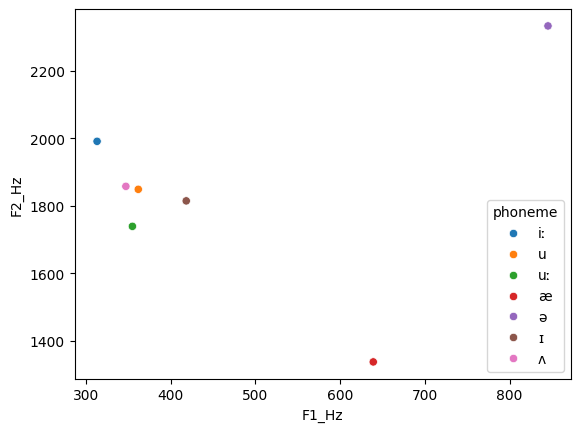

In [34]:
sns.scatterplot(data=grouped, x="F1_Hz", y="F2_Hz", hue="phoneme")